# Module 3: Amazon Bedrock AgentCore

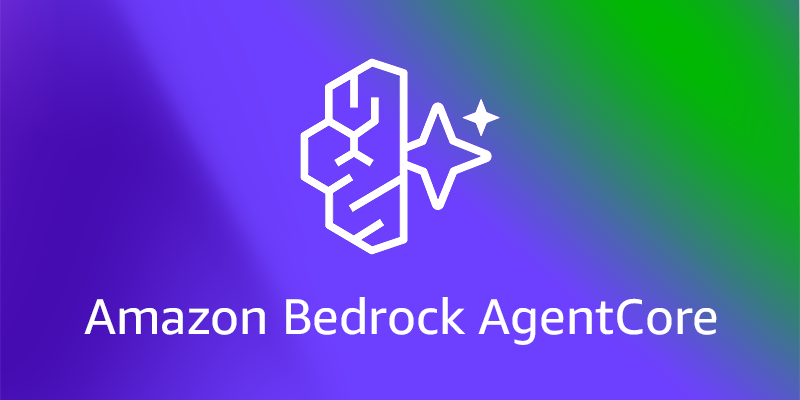

Amazon Bedrock AgentCore enables you to deploy and operate highly effective agents securely, at scale using any framework and model. With Amazon Bedrock AgentCore, developers can accelerate AI agents into production with the scale, reliability, and security, critical to real-world deployment. AgentCore provides tools and capabilities to make agents more effective and capable, purpose-built infrastructure to securely scale agents, and controls to operate trustworthy agents. Amazon Bedrock AgentCore services are composable and work with popular open-source frameworks and any model, so you don’t have to choose between open-source flexibility and enterprise-grade security and reliability.

**Services in Amazon Bedrock AgentCore**

Amazon Bedrock AgentCore includes the following modular Services that you can use together or independently:

**Amazon Bedrock AgentCore Runtime**

AgentCore Runtime is a secure, serverless runtime purpose-built for deploying and scaling dynamic AI agents and tools using any open-source framework including LangGraph, CrewAI, and Strands Agents, any protocol, and any model. Runtime was built to work for agentic workloads with industry-leading extended runtime support, fast cold starts, true session isolation, built-in identity, and support for multi-modal payloads. Developers can focus on innovation while Amazon Bedrock AgentCore Runtime handles infrastructure and security—accelerating time-to-market

**Amazon Bedrock AgentCore Identity**

AgentCore Identity provides a secure, scalable agent identity and access management capability accelerating AI agent development. It is compatible with existing identity providers, eliminating needs for user migration or rebuilding authentication flows. AgentCore Identity's helps to minimize consent fatigue with a secure token vault and allows you to build streamlined AI agent experiences. Just-enough access and secure permission delegation allow agents to securely access AWS resources and third-party tools and services.

**Amazon Bedrock AgentCore Memory**

AgentCore Memory makes it easy for developers to build context aware agents by eliminating complex memory infrastructure management while providing full control over what the AI agent remembers. Memory provides industry-leading accuracy along with support for both short-term memory for multi-turn conversations and long-term memory that can be shared across agents and sessions.

**Amazon Bedrock AgentCore Code Interpreter**

AgentCore Code Interpreter tool enables agents to securely execute code in isolated sandbox environments. It offers advanced configuration support and seamless integration with popular frameworks. Developers can build powerful agents for complex workflows and data analysis while meeting enterprise security requirements.

**Amazon Bedrock AgentCore Browser**

AgentCore Browser tool provides a fast, secure, cloud-based browser runtime to enable AI agents to interact with websites at scale. It provides enterprise-grade security, comprehensive observability features, and automatically scales— all without infrastructure management overhead.

**Amazon Bedrock AgentCore Gateway**

Amazon Bedrock AgentCore Gateway provides a secure way for agents to discover and use tools along with easy transformation of APIs, Lambda functions, and existing services into agent-compatible tools. Gateway eliminates weeks of custom code development, infrastructure provisioning, and security implementation so developers can focus on building innovative agent applications.

**Amazon Bedrock AgentCore Observability**

AgentCore Observability helps developers trace, debug, and monitor agent performance in production through unified operational dashboards. With support for OpenTelemetry compatible telemetry and detailed visualizations of each step of the agent workflow, AgentCore enables developers to easily gain visibility into agent behavior and maintain quality standards at scale.

**Common use cases for Amazon Bedrock AgentCore**

- *Equip agents with built-in tools and capabilities:* Leverage built-in tools (browser automation and code interpretation) in your agent. Enable agents to seamlessly integrate with internal and external tools and resources. Create agents that can remember interactions with your agent users.

- *Deploy securely at scale:* Securely deploy and scale dynamic AI agents and tools, regardless of framework, protocol, or model choice without managing any underlying resources with seamless agent identity and access management.

- *Test and monitor agents:* Gain deep operational insights with real-time visibility into agents' usage and operational metrics such as token usage, latency, session duration, and error rates.

In this module we will go over how you can take an AI Agent built using Strands SDK agent and deploy it on Amazon Bedrock AgentCore Runtime with just few lines of code.

### Exercise 1: Disk Monitoring Agent

In this exercise we will be converting the Disk Monitoring Agent we built in Module 2 using Strands Agents SDK and make it deployable using Amazon Bedrock AgentCore. 

Let's start by importing some Python libraries, including Strands SDK and BedrockAgentCoreApp - which will help us make this AI agent compatible to run on Amazon Bedrock AgentCore Runtime. Amazon Bedrock AgentCore enables you to deploy and operate highly capable AI agents securely at scale, providing infrastructure purpose-built for dynamic agent workloads with complete session isolation. Think of Strands SDK as the development framework and AgentCore as the production runtime infrastructure. AgentCore is both framework-agnostic and model-agnostic. You can use Strands, LangGraph, CrewAI, or any other framework, and run them on any LLM. 

In [11]:
%%writefile -a acrdisk.py
import boto3
import json
from datetime import datetime
from bedrock_agentcore import BedrockAgentCoreApp
from strands import Agent, tool

Writing acrdisk.py


**Initialize AgentCore Application**

The BedrockAgentCoreApp provides a lightweight wrapper that helps deploy agent functions as HTTP services compatible with Amazon Bedrock AgentCore. This single line of code sets up everything needed to run your agent as a production service. When you deploy, the toolkit automatically creates the IAM execution role, container image, and Amazon Elastic Container Registry repository needed to host the agent in AgentCore Runtime. This is a key differentiator — traditional deployment requires significant DevOps work (setting up Docker, configuring networking, managing secrets, etc.), but AgentCore abstracts all of that away. AgentCore Runtime provides industry-leading support for long-running workloads up to 8 hours with complete session isolation, which is crucial for complex agent tasks.

In [12]:
%%writefile -a acrdisk.py

app = BedrockAgentCoreApp()

Appending to acrdisk.py


**Helper Functions**

These are standard Python functions that interacts with AWS APIs. The important lesson here is that Strands Agents embraces the capabilities of state-of-the-art models to plan, chain thoughts, call tools, and reflect — you simply define a prompt and a list of tools in code to build an agent. These functions will eventually be wrapped by Strands' @tool decorator, transforming these helper functions into capabilities that an AI agent in AgentCore can invoke.

In [13]:
%%writefile -a acrdisk.py

def get_msk_clusters(region='us-west-2'):
    """Get all MSK clusters in the specified AWS region."""
    try:
        kafka_client = boto3.client('kafka', region_name=region)
        response = kafka_client.list_clusters_v2()
        clusters = response.get('ClusterInfoList', [])
        return [{
            'name': c['ClusterName'],
            'arn': c['ClusterArn'],
            'state': c['State']
        } for c in clusters]
    except Exception as e:
        print(f"Error getting clusters: {e}")
        return []

def get_broker_nodes(cluster_arn, region='us-west-2'):
    """Get broker node IDs for MSK cluster."""
    try:
        kafka_client = boto3.client('kafka', region_name=region)
        response = kafka_client.list_nodes(ClusterArn=cluster_arn)
        return [str(int(node['BrokerNodeInfo']['BrokerId'])) 
                for node in response.get('NodeInfoList', [])
                if node['NodeType'] == 'BROKER']
    except Exception:
        return []

def get_instant_broker_metrics(cluster_name, broker_id, metric_name, region='us-west-2'):
    """Get instant current metrics for specific broker."""
    try:
        from datetime import timedelta
        cloudwatch = boto3.client('cloudwatch', region_name=region)
        end_time = datetime.now()
        start_time = end_time - timedelta(minutes=5)
        
        response = cloudwatch.get_metric_statistics(
            Namespace='AWS/Kafka',
            MetricName=metric_name,
            Dimensions=[
                {'Name': 'Cluster Name', 'Value': cluster_name},
                {'Name': 'Broker ID', 'Value': str(broker_id)}
            ],
            StartTime=start_time,
            EndTime=end_time,
            Period=60,
            Statistics=['Average', 'Maximum']
        )
        return response['Datapoints']
    except Exception:
        return []

Appending to acrdisk.py


**Build AI Agents using Strands SDK**

As seen in Module 2, this is where the magic happens. The @tool decorator converts a Python function into a capability that the AI agent can invoke. Notice the function has type hints (cluster_name: str) and a clear docstring—these are essential because the LLM uses the function signature and docstring to understand when and how to use the tool. The function returns JSON, which is a best practice for agent tools because structured data is easier for LLMs to parse and reason about than unstructured text. Tools help agents achieve complex use cases in a model-driven approach—the model decides autonomously when to use tools based on the task at hand.

In [14]:
%%writefile -a acrdisk.py

@tool
def monitor_disk_usage(cluster_name: str, region: str = 'us-west-2') -> str:
    """Monitor disk usage across all brokers in the cluster."""
    clusters = get_msk_clusters(region)
    cluster_info = next((c for c in clusters if c['name'] == cluster_name), None)
    
    if not cluster_info:
        return json.dumps({'error': f'Cluster {cluster_name} not found'})
    
    broker_ids = get_broker_nodes(cluster_info['arn'], region)
    disk_status = {
        'cluster_name': cluster_name,
        'total_brokers': len(broker_ids),
        'broker_status': {},
        'critical_brokers': [],
        'warning_brokers': [],
        'overall_disk_health': 'healthy',
        'timestamp': datetime.now().isoformat()
    }
    
    for broker_id in broker_ids:
        broker_data = get_instant_broker_metrics(cluster_name, broker_id, 'KafkaDataLogsDiskUsed', region)
        if broker_data:
            latest_data = max(broker_data, key=lambda x: x['Timestamp'])
            usage = latest_data.get('Maximum', 0)
            disk_status['broker_status'][broker_id] = {
                'usage_percent': usage,
                'timestamp': latest_data['Timestamp'].isoformat()
            }
            
            if usage > 90:
                disk_status['critical_brokers'].append(f"Broker {broker_id}: {usage:.1f}%")
                disk_status['overall_disk_health'] = 'critical'
            elif usage > 60:
                disk_status['warning_brokers'].append(f"Broker {broker_id}: {usage:.1f}%")
                if disk_status['overall_disk_health'] == 'healthy':
                    disk_status['overall_disk_health'] = 'warning'
    
    return json.dumps(disk_status, indent=2)

Appending to acrdisk.py


**Configure LLM and initialize the Agent**

As discussed in our previous module, Strands SDK is model-agnostic and supports many different models from many different providers including Amazon Bedrock, Anthropic, Gemini, LiteLLM, Llama, Ollama, OpenAI, and Writer to name a few. Here we're using Claude 3.5 Sonnet through Amazon Bedrock. The model ID format us.anthropic.claude-3-5-sonnet-20241022-v2:0 is a cross-region inference profile, which means AWS automatically routes requests to the optimal region for availability and latency. 

The agent is defined by three core components: a model, tools, and a prompt. These work together in the "agentic loop" where the agent uses these components to complete tasks autonomously. Note *load_tools_from_directory=False* — this means we're explicitly providing tools rather than auto-discovering them from a directory.

In [15]:
%%writefile -a acrdisk.py

# Initialize agent with inference profile
from strands.models import BedrockModel

model = BedrockModel(
    model_id="us.anthropic.claude-3-5-sonnet-20241022-v2:0",
)
agent = Agent(
    model=model,
    tools=[monitor_disk_usage], 
    load_tools_from_directory=False,
    system_prompt="You are a disk monitoring agent helping users analyze Amazon MSK broker disk usage. Use tools available to gather required data."
)

Appending to acrdisk.py


**Define AgentCore Entrypoint**

The *@app.entrypoint* decorator marks this function as the entry point for agent invocations in AgentCore Runtime. When you deploy to AgentCore, this becomes an HTTP endpoint that receives JSON payloads and returns responses. The payload parameter contains the incoming request data — in this case, a user prompt, cluster name, and region. Notice we're calling *monitor_disk_usage()* directly before invoking the agent — this is a design choice for this workshop to ensure we always have fresh data. In a more sophisticated setup, you'd let the agent decide when to call tools based on the user's question. AgentCore Runtime handles all the infrastructure — you just write the function and AgentCore manages containers, scaling, and security. The function returns a dictionary that gets serialized to JSON automatically.

In [16]:
%%writefile -a acrdisk.py

@app.entrypoint
def invoke(payload):
    """Your AI agent function"""
    user_message = payload.get("prompt", "Hello! How can I help you today?")
    cluster_name = payload.get("cluster_name", "demo-cluster-1")
    region = payload.get("region", "us-west-2")
    
    # Use the tool to monitor disk usage
    disk_result = monitor_disk_usage(cluster_name, region)
    
    result = agent(f"Monitor disk usage for MSK cluster {cluster_name}: {disk_result}")
    return {"result": result.message}

if __name__ == "__main__":
    app.run()

Appending to acrdisk.py


### Exercise 2: MSK Cluster Management Agent using AWS MSK MCP Server

This agent builds on the concepts from the disk monitoring example but introduces Model Context Protocol (MCP) integration, which is a key advancement in agent architecture. 

**What is MCP and Why It Matters**

MCP (Model Context Protocol) is an open standard for connecting AI assistants to systems where data lives, including content repositories, business tools, and development environments. Its aim is to help models produce better, more relevant responses. Think of it as USB-C for AI—just as USB-C provides a standardized way to connect your devices to peripherals, MCP provides a standardized way to connect AI models to various data sources and tools.

In the previous example, we wrote custom Python functions to interact with AWS APIs directly. With MCP, we're connecting to a pre-built MCP server (awslabs.aws-msk-mcp-server) that already implements best practices for MSK operations. This is significant because:

- Reusability: AWS Labs maintains this MCP server—you don't write or maintain the integration code
- Standardization: MCP replaces fragmented integrations with a single protocol, meaning the same pattern works for Google Drive, Slack, GitHub, etc.

Go ahead and execute the next cell to build your second agent using MCP that can be deployed on Amazon Bedrock AgentCore.

In [17]:
%%writefile -a acrmcp.py

import boto3
import asyncio
import re
from datetime import datetime, timedelta
from bedrock_agentcore import BedrockAgentCoreApp
from strands import Agent
from strands.models import BedrockModel

app = BedrockAgentCoreApp()

try:
    from mcp import ClientSession, StdioServerParameters
    from mcp.client.stdio import stdio_client
    MCP_AVAILABLE = True
except ImportError:
    MCP_AVAILABLE = False

def get_msk_clusters(region='us-west-2'):
    """Get all MSK clusters in the specified AWS region."""
    try:
        kafka_client = boto3.client('kafka', region_name=region)
        response = kafka_client.list_clusters_v2()
        clusters = response.get('ClusterInfoList', [])
        return [{
            'name': c['ClusterName'],
            'arn': c['ClusterArn'],
            'state': c['State']
        } for c in clusters]
    except Exception as e:
        print(f"Error getting clusters: {e}")
        return []

def get_cluster_arn(cluster_name, region):
    """Get cluster ARN from cluster name"""
    try:
        clusters = get_msk_clusters(region)
        cluster_info = next((c for c in clusters if c['name'] == cluster_name), None)
        return cluster_info['arn'] if cluster_info else None
    except Exception:
        return None

def run_mcp_tool(tool_name, arguments=None):
    """Synchronous wrapper for AWS MSK MCP tool calls"""
    if not MCP_AVAILABLE:
        return "MCP not available - install with: pip install mcp"
    
    async def _call_mcp():
        try:
            server_params = StdioServerParameters(
                command="uvx",
                args=["awslabs.aws-msk-mcp-server@latest", "--allow-writes"],
                env={"FASTMCP_LOG_LEVEL": "ERROR", "PYTHONUNBUFFERED": "1"}
            )
            
            async with stdio_client(server_params) as (read, write):
                async with ClientSession(read, write) as session:
                    await session.initialize()
                    result = await session.call_tool(tool_name, arguments or {})
                    return result.content[0].text if result.content else ""
        except Exception as e:
            return f"MCP Error: {str(e)}"
    
    try:
        return asyncio.run(_call_mcp())
    except Exception as e:
        return f"MCP Error: {str(e)}"

from strands import tool

@tool
def process_mcp_request(prompt, cluster_name, region):
    """Process MCP request using AWS MSK MCP server"""
    prompt_lower = prompt.lower()
    numbers = re.findall(r'\d+', prompt)
    
    if any(word in prompt_lower for word in ['reboot', 'restart']) and 'broker' in prompt_lower:
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            # Extract broker IDs if specified
            broker_ids = re.findall(r'broker\s*(\d+)', prompt_lower)
            raw_response = run_mcp_tool("reboot_broker", {
                "cluster_arn": cluster_arn,
                "broker_ids": broker_ids if broker_ids else None,
                "region": region
            })
            return raw_response
    
    elif any(word in prompt_lower for word in ['instance', 'broker type', 'update type']) and ('update' in prompt_lower or 'change' in prompt_lower or 'scale' in prompt_lower):
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            instance_match = re.search(r'(kafka\.\w+\.\w+)', prompt_lower)
            if instance_match:
                instance_type = instance_match.group(1)
                raw_response = run_mcp_tool("update_broker_type", {
                    "cluster_arn": cluster_arn,
                    "instance_type": instance_type,
                    "region": region
                })
            else:
                raw_response = "Please specify the target instance type (e.g., kafka.m5.large)"
            return f"🔧 Broker type update for {cluster_name}: {raw_response}"
        else:
            return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif any(word in prompt_lower for word in ['instance', 'broker type', 'instance type']):
        # Just asking about instance type, not updating
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            raw_response = run_mcp_tool("get_cluster_info", {
                "cluster_arn": cluster_arn,
                "region": region,
                "info_type": "metadata"
            })
            return raw_response
        else:
            return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif any(word in prompt_lower for word in ['storage', 'disk', 'volume']):
        print(f"🔍 DEBUG - Storage request detected: {prompt}")
        if ('increase' in prompt_lower or 'update' in prompt_lower) and numbers:
            target_gib = int(numbers[0])
            print(f"🔍 DEBUG - Storage update requested: {target_gib}GB")
            cluster_arn = get_cluster_arn(cluster_name, region)
            if cluster_arn:
                # Get current version first
                cluster_info = run_mcp_tool("get_cluster_info", {
                    "cluster_arn": cluster_arn,
                    "region": region,
                    "info_type": "metadata"
                })
                
                # Extract current version
                import json
                current_version = None
                try:
                    if '"CurrentVersion"' in str(cluster_info):
                        version_match = re.search(r'"CurrentVersion":\s*"([^"]+)"', str(cluster_info))
                        current_version = version_match.group(1) if version_match else None
                except:
                    pass
                
                if current_version:
                    print(f"🔍 DEBUG - Calling update_broker_storage with current_version: {current_version}")
                    raw_response = run_mcp_tool("update_broker_storage", {
                        "region": region,
                        "cluster_arn": cluster_arn,
                        "current_version": current_version,
                        "target_broker_ebs_volume_info": {
                            "KafkaBrokerNodeId": "ALL",
                            "VolumeSizeGB": target_gib
                        }
                    })
                else:
                    raw_response = "❌ Could not retrieve current cluster version"
                print(f"🔍 DEBUG - Storage update response: {raw_response}")
                return f"💾 Storage update for {cluster_name} to {target_gib}GB: {raw_response}"
            else:
                return f"❌ Cluster '{cluster_name}' not found in region {region}"
        else:
            cluster_arn = get_cluster_arn(cluster_name, region)
            if cluster_arn:
                raw_response = run_mcp_tool("get_cluster_info", {
                    "cluster_arn": cluster_arn,
                    "region": region
                })
                return raw_response
            else:
                return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif 'broker count' in prompt_lower or 'scale' in prompt_lower:
        if ('increase' in prompt_lower or 'update' in prompt_lower) and numbers:
            new_count = int(numbers[0])
            cluster_arn = get_cluster_arn(cluster_name, region)
            if cluster_arn:
                raw_response = run_mcp_tool("update_broker_count", {
                    "cluster_name": cluster_name,
                    "cluster_arn": cluster_arn,
                    "target_number_of_broker_nodes": new_count,
                    "region": region
                })
                return f"📈 Broker scaling for {cluster_name} to {new_count} brokers: {raw_response}"
            else:
                return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif any(word in prompt_lower for word in ['health', 'status', 'details']) and 'cluster' in prompt_lower:
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            raw_response = run_mcp_tool("get_cluster_info", {
                "cluster_arn": cluster_arn,
                "region": region
            })
            return f"🏥 Cluster health status for {cluster_name}: {raw_response}"
        else:
            return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif 'telemetry' in prompt_lower or 'metrics' in prompt_lower:
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            end_time = datetime.utcnow()
            start_time = end_time - timedelta(hours=1)
            
            raw_response = run_mcp_tool("get_cluster_telemetry", {
                "action": "metrics",
                "cluster_arn": cluster_arn,
                "region": region,
                "kwargs": {
                    "start_time": start_time.isoformat(),
                    "end_time": end_time.isoformat(),
                    "period": 300,
                    "metrics": ["GlobalTopicCount", "GlobalPartitionCount", "OfflinePartitionsCount", "UnderReplicatedPartitions"]
                }
            })
            return f"📈 Telemetry metrics for {cluster_name}: {raw_response}"
        else:
            return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif 'best practices' in prompt_lower or 'recommendations' in prompt_lower:
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            raw_response = run_mcp_tool("get_cluster_best_practices", {
                "cluster_name": cluster_name,
                "cluster_arn": cluster_arn,
                "region": region
            })
            return f"💡 Best practices for {cluster_name}: {raw_response}"
        else:
            return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif any(word in prompt_lower for word in ['operation', 'status']) and ('cluster' in prompt_lower or 'check' in prompt_lower or 'arn' in prompt_lower):
        # Extract operation ARN if provided
        arn_match = re.search(r'(arn:aws:kafka:[^:]+:[^:]+:operation/[^\s]+)', prompt)
        if arn_match:
            operation_arn = arn_match.group(1)
            raw_response = run_mcp_tool("describe_cluster_operation", {
                "cluster_operation_arn": operation_arn,
                "region": region
            })
            return raw_response
        else:
            return "Please provide the operation ARN to check status"
    
    else:
        # Default to cluster info
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            raw_response = run_mcp_tool("get_cluster_info", {
                "cluster_arn": cluster_arn,
                "region": region
            })
            return raw_response
        else:
            return f"❌ Cluster '{cluster_name}' not found in region {region}"

# Initialize agent with inference profile
from strands.models import BedrockModel

model = BedrockModel(
    model_id="us.anthropic.claude-3-5-sonnet-20241022-v2:0",
)
agent = Agent(
    model=model,
    tools=[process_mcp_request], 
    load_tools_from_directory=False,
    system_prompt="You are a MCP monitoring agent helping users analyze and manage Amazon MSK clusters. You can perform cluster operations including storage updates, broker reboots, scaling, and monitoring. When users request storage updates (like 'increase volume to X GB'), broker reboots, scaling operations, or cluster analysis, use the process_mcp_request tool. Always highlight key information like instance types, storage sizes, and broker counts in your responses."
)

@app.entrypoint
def invoke(payload):
    """AI agent entrypoint"""
    print(f"🔍 DEBUG - Received payload: {payload}")
    
    cluster_name = payload.get("cluster_name")
    region = payload.get("region")
    user_message = payload.get("prompt", f"Analyze the MSK cluster {cluster_name} using Amazon MSK MCP tools")
    
    print(f"🔍 DEBUG - Processing: cluster={cluster_name}, region={region}")
      
    result = agent(f"{user_message}. Cluster: '{cluster_name}', Region: '{region}'")
    
    print(f"🔍 DEBUG - Agent result: {result}")
    print(f"🔍 DEBUG - Result message: {result.message}")
    
    return {"result": result.message}

if __name__ == "__main__":
    app.run()

Writing acrmcp.py


### Exercise 3: Deploy and Host AI Agents on Amazon Bedrock AgentCore

Amazon Bedrock AgentCore Runtime provides a secure, serverless and purpose-built hosting environment for deploying and running AI agents or tools. 

=== Deployment Steps ===

1. NAVIGATE TO RIGHT DIRECTORY IN A TERMINAL
   - Open a new Terminal by clicking File > New > Terminal
   - Activate your virtual enironment ***source venv/bin/activate***
   - Type ***cd sps-workshop*** and hit enter to navigate to sps-workshop directory
   - Type ***ls*** and hit enter. Confirm both agent files are listed (acrdisk.py and acrmcp.py)
     
2. CONFIGURE DISK MONITORING AGENT:
   - Type ***agentcore configure --entrypoint acrdisk.py*** and hit enter
   - This command:
       - Generates a Dockerfile and .dockerignore
       - Creates a .bedrock_agentcore.yaml configuration file
       - Sets up IAM roles and ECR repository settings

3. DEPLOY TO AWS:
   - Type ***agentcore launch*** 
   - This command:
       - Builds a container using AWS CodeBuild (no local Docker needed!)
       - Pushes the image to Amazon ECR
       - Creates a Bedrock AgentCore runtime
       - Deploys your agent to the cloud
         
4. CONFIGURE MSK MANAGEMENT AGENT:
   - Type ***agentcore configure --entrypoint acrmcp.py*** and hit enter
   - This command:
       - Generates a Dockerfile and .dockerignore
       - Creates a .bedrock_agentcore.yaml configuration file
       - Sets up IAM roles and ECR repository settings

5. DEPLOY TO AWS:
   - Type ***agentcore launch*** 
   - This command:
       - Builds a container using AWS CodeBuild (no local Docker needed!)
       - Pushes the image to Amazon ECR
       - Creates a Bedrock AgentCore runtime
       - Deploys your agent to the cloud
       - Add required Amazon MSK permissions to Agentcore Runtime Agent's Execution Role.


### Exercise 4: Deploy front-end Streamlit App to interact with Agents in AgentCore

Finally, in this exercise we will deploy Streamlit application that demonstrates the complete architecture for AI agents: development → deployment → user interface.

The important thing to note here is how the Streamlit application calls or invokes the agent hosted on Amazon Bedrock AgentCore: 

```
def invoke_agent(agent_name, prompt, cluster_name, region="us-west-2"):
    payload = {"prompt": prompt, "cluster_name": cluster_name, "region": region}
    cmd = f"agentcore invoke '{json.dumps(payload)}'"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True, timeout=180)
```

An alternative approach would also be to use boto3 client to invoke the agent, as shown here: 

```
client = boto3.client('bedrock-agentcore')
response = client.invoke_agent_runtime(agentId='...', inputText='...')
```

Before we run, we need to grab  

In [ ]:
%%writefile -a agentcore_streamlit_app.py

import streamlit as st
import json
import boto3
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta
import uuid
import os
import re

def format_disk_with_bedrock(text):
    """Use Bedrock to format MSK response into readable format"""
    try:
        bedrock = boto3.client('bedrock-runtime', region_name='us-west-2')
        
        prompt = f"""You are an AWS MSK expert. Convert this raw JSON response into a clean, human-readable summary with emojis and clear sections.

Raw response:
{text}

Please format this into a natural language summary that includes:
- Cluster details (name, status, type, etc.)
- Connection endpoints if available
- Broker information if available
- Security settings if available
- Recent operations if available

Make it concise, well-organized, and easy to understand. Use emojis for different sections."""
        
        response = bedrock.invoke_model(
            modelId='anthropic.claude-3-5-sonnet-20241022-v2:0',
            body=json.dumps({
                "anthropic_version": "bedrock-2023-05-31",
                "max_tokens": 2000,
                "messages": [{"role": "user", "content": prompt}]
            })
        )
        
        try:
            result = json.loads(response['body'].read())
            return result['content'][0]['text']
        except json.JSONDecodeError as e:
            # Handle truncated JSON response
            raw_response = response['body'].read().decode('utf-8')
            text_match = re.search(r'"text":\s*"([^"]*)', raw_response)
            if text_match:
                return text_match.group(1)
            return f"Bedrock JSON parse error: {str(e)}"
    except Exception as e:
        return f"Bedrock formatting error: {str(e)}\n\nOriginal text: {text}"

def format_mcp_with_bedrock(text):
    """Use Bedrock to format MCP response into readable format"""
    try:
        # Check if text is already an error message
        if isinstance(text, str) and ("JSON Parse Error" in text or "Agent invocation error" in text):
            return f"⚠️ **Error occurred:**\n\n{text}\n\n💡 **Suggestion:** Try refreshing the page or selecting the cluster again."
        
        bedrock = boto3.client('bedrock-runtime', region_name='us-west-2')
        
        prompt = f"""You are an AWS MSK expert. Convert this raw JSON response into a clean, human-readable summary with emojis and clear sections.

Raw response:
{text}

Please format this into a natural language summary that includes:
- Cluster details (name, status, type, etc.)
- Connection endpoints if available
- Broker information if available
- Security settings if available
- Recent operations if available

Make it concise, well-organized, and easy to understand. Use emojis for different sections."""
        
        response = bedrock.invoke_model(
            modelId='anthropic.claude-3-5-sonnet-20241022-v2:0',
            body=json.dumps({
                "anthropic_version": "bedrock-2023-05-31",
                "max_tokens": 4000,
                "messages": [{"role": "user", "content": prompt}]
            })
        )
        
        # Read response body once
        raw_response = response['body'].read().decode('utf-8')
        
        try:
            result = json.loads(raw_response)
            return result['content'][0]['text']
        except json.JSONDecodeError:
            # Try to extract text content using regex patterns
            patterns = [
                r'"text":\s*"(.*?)"(?=\s*[,}])',  # Complete text field
                r'"text":\s*"([^"]*)',            # Partial text field
                r'"content":\s*\[\s*{\s*"text":\s*"([^"]*)'  # Nested content
            ]
            
            for pattern in patterns:
                match = re.search(pattern, raw_response, re.DOTALL)
                if match:
                    extracted_text = match.group(1)
                    # Clean up escaped characters
                    extracted_text = extracted_text.replace('\\"', '"').replace('\\n', '\n')
                    return extracted_text
            
            # If no text found, return formatted error
            return f"⚠️ **Response Processing Error**\n\nUnable to parse Bedrock response. Raw response preview:\n```\n{raw_response[:200]}...\n```\n\n💡 **Suggestion:** Try refreshing the page or selecting the cluster again."
    except Exception as e:
        return f"Bedrock formatting error: {str(e)}\n\nOriginal text: {text}"

def parse_nested_response(raw_data):
    """Parse nested JSON response structure"""
    try:
        outer = json.loads(raw_data)
        content_str = outer["output"]["messages"][1]["content"]["message"]
        inner = json.loads(content_str)
        return inner[0]["text"]
    except (json.JSONDecodeError, KeyError, IndexError):
        return None

def invoke_agent(agent_name, prompt, cluster_name, region="us-west-2"):
    """Invoke agent using Bedrock AgentCore client"""
    try:
        agent_arns = {
            "mcpagent": "<acrmcp-AGENTCORE RUNTIME ARN>",
            "disk": "<acrdisk-AGENTCORE RUNTIME ARN>"
        }
        
        clusters = get_msk_clusters(region)
        cluster_arn = None
        for cluster in clusters:
            if cluster['name'] == cluster_name:
                cluster_arn = cluster['arn']
                break
        
        if not cluster_arn:
            return f"Cluster '{cluster_name}' not found in region {region}"
        
        payload = {
            "prompt": prompt,
            "cluster_name": cluster_name,
            "cluster_arn": cluster_arn,
            "region": region
        }
        
        agent_arn = agent_arns.get(agent_name, agent_name)
        agentcore_client = boto3.client('bedrock-agentcore', region_name=region)
        
        boto3_response = agentcore_client.invoke_agent_runtime(
            agentRuntimeArn=agent_arn,
            qualifier="DEFAULT",
            payload=json.dumps(payload)
        )
        
        # Read full response body
        response_body = boto3_response["response"].read().decode("utf-8")
        
        # Try nested JSON parsing first
        parsed_content = parse_nested_response(response_body)
        if parsed_content:
            return parsed_content
        
        # Fallback to original parsing
        try:
            result = json.loads(response_body)
            return result.get('result', result)
        except json.JSONDecodeError:
            if '"result"' in response_body:
                result_match = re.search(r'"result":\s*"([^"]*(?:\\.[^"]*)*)"', response_body)
                if result_match:
                    return result_match.group(1).replace('\\"', '"').replace('\\n', '\n')
            return f"JSON Parse Error. Raw: {response_body[:200]}..."
            
    except Exception as e:
        return f"Agent invocation error: {str(e)}"

def get_msk_clusters(region):
    """Get MSK clusters with detailed info"""
    try:
        kafka_client = boto3.client('kafka', region_name=region)
        response = kafka_client.list_clusters_v2()
        clusters = response.get('ClusterInfoList', [])
        return [{
            'name': c['ClusterName'],
            'arn': c['ClusterArn'],
            'state': c['State'],
            'kafka_version': c.get('Provisioned', {}).get('CurrentBrokerSoftwareInfo', {}).get('KafkaVersion', 'Unknown')
        } for c in clusters]
    except Exception:
        return []

def get_broker_nodes(cluster_arn, region='us-west-2'):
    """Get broker node IDs for MSK cluster"""
    try:
        kafka_client = boto3.client('kafka', region_name=region)
        response = kafka_client.list_nodes(ClusterArn=cluster_arn)
        
        return [str(int(node['BrokerNodeInfo']['BrokerId'])) 
                for node in response.get('NodeInfoList', [])
                if node['NodeType'] == 'BROKER']
    except Exception:
        return []

def get_instant_broker_metrics(cluster_name, broker_id, metric_name, region='us-west-2'):
    """Get instant current metrics for specific broker"""
    try:
        cloudwatch = boto3.client('cloudwatch', region_name=region)
        end_time = datetime.now()
        start_time = end_time - timedelta(minutes=5)
        
        response = cloudwatch.get_metric_statistics(
            Namespace='AWS/Kafka',
            MetricName=metric_name,
            Dimensions=[
                {'Name': 'Cluster Name', 'Value': cluster_name},
                {'Name': 'Broker ID', 'Value': str(broker_id)}
            ],
            StartTime=start_time,
            EndTime=end_time,
            Period=60,
            Statistics=['Average', 'Maximum']
        )
        return response['Datapoints']
    except Exception:
        return []

def get_broker_metrics(cluster_name, broker_id, metric_name, hours, region):
    """Get broker metrics from CloudWatch"""
    try:
        cloudwatch = boto3.client('cloudwatch', region_name=region)
        end_time = datetime.now()
        start_time = end_time - timedelta(hours=hours)
        
        response = cloudwatch.get_metric_statistics(
            Namespace='AWS/Kafka',
            MetricName=metric_name,
            Dimensions=[
                {'Name': 'Cluster Name', 'Value': cluster_name},
                {'Name': 'Broker ID', 'Value': str(broker_id)}
            ],
            StartTime=start_time,
            EndTime=end_time,
            Period=300,
            Statistics=['Maximum']
        )
        
        return [{'Timestamp': dp['Timestamp'], 'Maximum': dp['Maximum']} 
                for dp in response['Datapoints']]
    except Exception:
        return []

def create_disk_metrics_graph(cluster_name, region='us-west-2', hours=24):
    """Create CloudWatch metrics graph for broker disk usage."""
    clusters = get_msk_clusters(region)
    cluster_info = next((c for c in clusters if c['name'] == cluster_name), None)
    
    if not cluster_info:
        return None
    
    broker_ids = get_broker_nodes(cluster_info['arn'], region)
    
    if not broker_ids:
        return None
    
    fig = go.Figure()
    
    for broker_id in broker_ids:
        broker_data = get_broker_metrics(cluster_name, broker_id, 'KafkaDataLogsDiskUsed', hours, region)
        
        if broker_data:
            df = pd.DataFrame(broker_data)
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df = df.sort_values('Timestamp')
            
            fig.add_trace(go.Scatter(
                x=df['Timestamp'],
                y=df['Maximum'],
                mode='lines+markers',
                name=f'Broker {broker_id}',
                line=dict(width=2)
            ))
    
    fig.add_hline(y=60, line_dash="dash", line_color="orange", annotation_text="Warning (60%)")
    fig.add_hline(y=80, line_dash="dash", line_color="red", annotation_text="Critical (80%)")
    
    fig.update_layout(
        title=f'MSK Broker Disk Usage - {cluster_name}',
        xaxis_title='Time',
        yaxis_title='Disk Usage (%)',
        height=400
    )
    
    return fig

def test_agent_connectivity(cluster_name="demo-cluster-1"):
    """Test AgentCore runtime availability"""
    connectivity_status = {}
    
    agents = {
        "mcpagent": "<acrmcp-AGENTCORE RUNTIME ARN>",
        "disk": "<acrdisk-AGENTCORE RUNTIME ARN>"
    }
    
    for agent_name, agent_arn in agents.items():
        try:
            result = invoke_agent(agent_name, "test connection", cluster_name)
            # Check if we got any valid response (not an error message)
            if result and not str(result).startswith("Agent invocation error:"):
                connectivity_status[agent_name] = "🟢 Runtime Ready"
            else:
                connectivity_status[agent_name] = f"🔴 Runtime Unavailable: {result}"
        except Exception as e:
            connectivity_status[agent_name] = f"🔴 Runtime Unavailable: {str(e)}"
    
    return connectivity_status

# Streamlit UI
st.title("🤖 Amazon MSK AgentCore Runtime Monitor")
st.markdown("*Amazon Bedrock AgentCore Runtime Agents for Amazon MSK Cluster Management*")

# Configuration
region = "us-west-2"
clusters = get_msk_clusters(region)

if not clusters:
    st.warning("No MSK clusters found")
    clusters = [{"name": "demo-cluster-1", "state": "ACTIVE"}]

selected_cluster = st.selectbox("Select Cluster", [c['name'] for c in clusters], key="cluster_selector_1")

# Agent Status
st.sidebar.header("🤖 AgentCore Runtime Status")
connectivity = test_agent_connectivity(selected_cluster)
for agent_name, status in connectivity.items():
    st.sidebar.text(f"{agent_name}: {status}")

# Test connectivity button
if st.sidebar.button("Refresh Agent Status"):
    with st.spinner("Testing AgentCore runtime..."):
        connectivity = test_agent_connectivity(selected_cluster)
        st.sidebar.success("Agent status refreshed!")
        for agent_name, status in connectivity.items():
            st.sidebar.text(f"{agent_name}: {status}")

# Tabs for different agents
tab1, tab2 = st.tabs(["🔧 Amazon MSK MCP Agent", "💾 Amazon MSK Disk Monitor"])

with tab1:
    st.header("Amazon MSK MCP Troubleshooting Assistant")
    
    # Chat interface
    if 'chat_history' not in st.session_state:
        st.session_state.chat_history = []
    
    # Display chat history
    for message in st.session_state.chat_history:
        if message['role'] == 'user':
            st.chat_message("user").write(message['content'])
        else:
            st.chat_message("assistant").write(message['content'])
    
    # Chat input
    if prompt := st.chat_input("Ask MCP Agent about MSK operations..."):
        st.session_state.chat_history.append({"role": "user", "content": prompt})
        st.chat_message("user").write(prompt)
        
        with st.chat_message("assistant"):
            with st.spinner("Processing MCP request..."):
                mcp_response = invoke_agent(
                    "mcpagent",
                    prompt,
                    selected_cluster,
                    region
                )
                
                # Format and display the response
                try:
                    # Check if mcp_response is already a string (error message)
                    if isinstance(mcp_response, str):
                        formatted_response = format_mcp_with_bedrock(mcp_response)
                    else:
                        formatted_response = format_mcp_with_bedrock(json.dumps(mcp_response, indent=2))
                except Exception as e:
                    formatted_response = f"⚠️ **Formatting Error:**\n\n{str(e)}\n\n**Raw Response:**\n{str(mcp_response)}"
                
                st.write(formatted_response)
                st.session_state.chat_history.append({"role": "assistant", "content": formatted_response})
    
    # Clear chat
    if st.button("Clear Chat", key="clear_chat"):
        st.session_state.chat_history = []
        st.rerun()

with tab2:
    st.header("💾 Disk Usage Monitoring Agent")
    
    if selected_cluster:
        # Real-time current disk usage
        st.subheader("🔴 Live Disk Usage of brokers in selected cluster (1-minute data)")
        
        col1, col2 = st.columns([3, 1])
        with col2:
            auto_refresh = st.checkbox("Auto-refresh (30s)")
            if st.button("🔄 Refresh Now") or auto_refresh:
                st.rerun()
        
        # Get instant disk metrics
        clusters_info = get_msk_clusters(region)
        cluster_info = next((c for c in clusters_info if c['name'] == selected_cluster), None)
        
        if cluster_info:
            broker_ids = get_broker_nodes(cluster_info['arn'], region)
            
            if broker_ids:
                current_usage = {}
                for broker_id in broker_ids:
                    broker_data = get_instant_broker_metrics(selected_cluster, broker_id, 'KafkaDataLogsDiskUsed', region)
                    if broker_data:
                        latest_data = max(broker_data, key=lambda x: x['Timestamp'])
                        current_usage[broker_id] = {
                            'usage': latest_data.get('Maximum', 0),
                            'timestamp': latest_data['Timestamp']
                        }
                
                # Display current usage
                if current_usage:
                    cols = st.columns(len(broker_ids))
                    for i, (broker_id, data) in enumerate(current_usage.items()):
                        with cols[i]:
                            usage = data['usage']
                            if usage > 90:
                                st.error(f"🔴 Broker {broker_id}\n{usage:.1f}% CRITICAL")
                            elif usage > 60:
                                st.warning(f"🟡 Broker {broker_id}\n{usage:.1f}% WARNING")
                            else:
                                st.success(f"🟢 Broker {broker_id}\n{usage:.1f}% NORMAL")
                            
                            st.caption(f"Updated: {data['timestamp'].strftime('%H:%M:%S')}")
                else:
                    st.info("No current disk usage data available")
        
        # CloudWatch metrics graph
        st.subheader("CloudWatch Disk Usage Metrics")
        hours = st.selectbox("Time Range", [1, 6, 12, 24], index=3, key="hours_range", 
                            format_func=lambda x: f"{x} hour{'s' if x > 1 else ''}")
        disk_fig = create_disk_metrics_graph(selected_cluster, region, hours)
        if disk_fig:
            st.plotly_chart(disk_fig, use_container_width=True)
        else:
            st.info("No disk metrics data available")
        
        # Agent monitoring
        st.subheader("Agent Analysis")
        if st.button("Monitor Disk Usage"):
            with st.spinner("Disk Monitoring Agent scanning..."):
                prompt = f"Analyze disk usage for MSK cluster {selected_cluster} in region {region}"
                disk_response = invoke_agent("disk", prompt, selected_cluster, region)
                formatted_response = format_disk_with_bedrock(json.dumps(disk_response, indent=2))
                st.write(formatted_response)
        
        # Auto-refresh logic
        if auto_refresh:
            import time
            time.sleep(30)
            st.rerun()

# Footer
st.markdown("---")
st.markdown(f"**Selected Cluster:** `{selected_cluster}` | **Region:** `{region}`")

Writing agentcore_streamlit_app.py


### Run Streamlit Application 
Lets now run the Streamlit application! 

First, we need to activate the virtualenv for Module 3.

In [19]:
!source venv/bin/activate

To make it easy to run the streamlit application, we have provide a shell script. Let's first make it executable. 

Run the next cell. 

In [20]:
!chmod +x run-module-3.sh

Next, open a new Terminal, *cd* into the directory where you have *app.py* file and run the following command to start the Streamlit application: 

```
bash run-module-3.sh
```

The run-module-3.sh script is designed to simply running a streamlit application on Jupyterlab notebook. It automatically collects/verifies the Amazon Sagemaker AI Studio App ID (it's the first part of the URL above https://**Sagemaker_Studio_App_ID**.studio.us-east-2.sagemaker.aws/), converts the default Streamlit app URL into a port forwarded public URL that you can simply click to open your Streamlit application. 

Go ahead execute the run-module-3.sh script to view your Streamlit application!